In [1]:
# ===============================================================
# FashionMNIST Classification using ANN, CNN & RBFN
# Includes Data Augmentation, Dropout, Adam vs SGD, F1 Score, and Full Analysis
# ===============================================================

!pip install torch torchvision matplotlib scikit-learn pandas -q

In [2]:
# -----------------------------
# 1 Import Dependencies
# -----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# -----------------------------
# 2 Data Preprocessing + Augmentation
# -----------------------------
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 176kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.28MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.2MB/s]


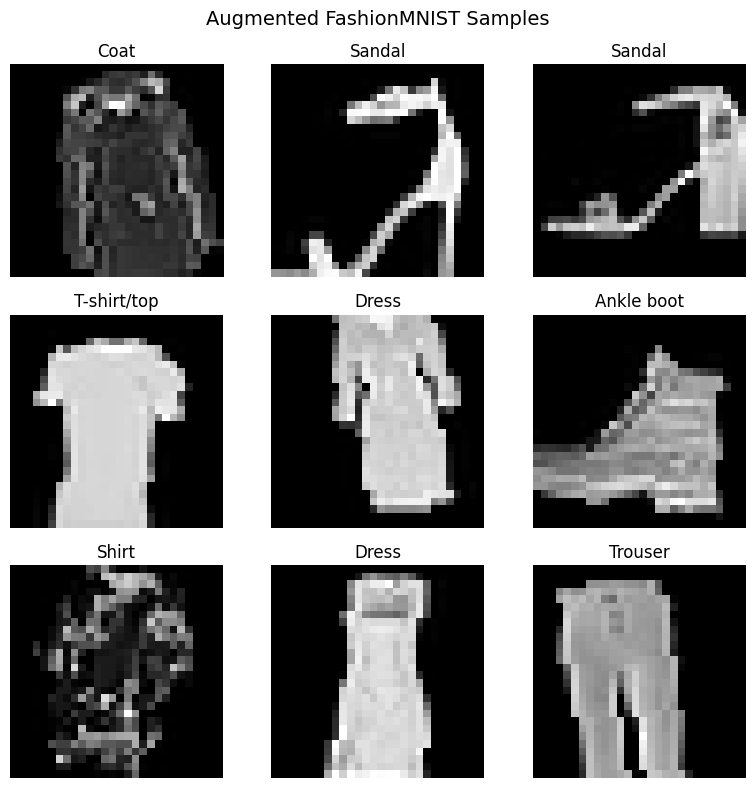

In [4]:
# -----------------------------
# 3 Visualize Augmented Images
# -----------------------------
images, labels = next(iter(train_loader))
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = images[i].squeeze().numpy()
    plt.imshow(img, cmap='gray')
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.suptitle("Augmented FashionMNIST Samples", fontsize=14)
plt.tight_layout()
plt.show()

In [5]:
# -----------------------------
# 4 Define ANN and CNN Models
# -----------------------------
class ANN(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super(ANN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

class CNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# -----------------------------
# NEW: Radial Basis Function Network (RBFN)
# -----------------------------
class RBFLayer(nn.Module):
    """
    Radial Basis Function Layer
    Computes Gaussian RBF: exp(-gamma * ||x - center||^2)
    """
    def __init__(self, in_features, out_features):
        super(RBFLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # RBF centers (learnable)
        self.centers = nn.Parameter(torch.randn(out_features, in_features))

        # RBF width (learnable)
        self.log_sigmas = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        # x: (batch, in_features)
        # centers: (out_features, in_features)

        # Compute squared distances to all centers
        # Expand dimensions for broadcasting
        x_expanded = x.unsqueeze(1)  # (batch, 1, in_features)
        centers_expanded = self.centers.unsqueeze(0)  # (1, out_features, in_features)

        # Squared Euclidean distance
        distances = torch.sum((x_expanded - centers_expanded) ** 2, dim=2)  # (batch, out_features)

        # Apply Gaussian RBF
        sigmas = torch.exp(self.log_sigmas)
        rbf_output = torch.exp(-distances / (2 * sigmas ** 2))

        return rbf_output


class RBFN(nn.Module):
    """
    Radial Basis Function Network
    Architecture: Input -> RBF Layer -> Linear Output
    """
    def __init__(self, input_dim=784, hidden_dim=100, output_dim=10):
        super(RBFN, self).__init__()
        self.flatten = nn.Flatten()
        self.rbf_layer = RBFLayer(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.flatten(x)
        rbf_out = self.rbf_layer(x)
        output = self.output_layer(rbf_out)
        return output

    def initialize_centers_with_kmeans(self, data_loader, n_samples=5000):
        """
        Initialize RBF centers using K-Means clustering
        This helps the network start with meaningful prototypes
        """
        print("Initializing RBFN centers with K-Means...")

        # Collect sample data
        samples = []
        count = 0
        for images, _ in data_loader:
            images = images.view(images.size(0), -1)
            samples.append(images)
            count += images.size(0)
            if count >= n_samples:
                break

        samples = torch.cat(samples, dim=0)[:n_samples].numpy()

        # K-Means clustering
        n_centers = self.rbf_layer.out_features
        kmeans = KMeans(n_clusters=n_centers, random_state=42, n_init=10)
        kmeans.fit(samples)

        # Set centers
        self.rbf_layer.centers.data = torch.FloatTensor(kmeans.cluster_centers_)
        print(f"Initialized {n_centers} RBF centers using K-Means")


In [6]:
# -----------------------------
# 5 Training & Evaluation Functions
# -----------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, model_name="Model"):
    model.to(device)
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, val_accuracies


def test_model(model, test_loader, model_name):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"\nClassification Report ({model_name}):\n")
    print(classification_report(y_true, y_pred, target_names=classes))
    cm = confusion_matrix(y_true, y_pred)
    acc = 100 * np.mean(np.array(y_true) == np.array(y_pred))
    return acc, cm, f1


In [7]:
# -----------------------------
# 6 Train all models
# -----------------------------
criterion = nn.CrossEntropyLoss()

models_results = []
all_train_losses = {}
all_val_losses = {}

# ANN - Adam
print("\n" + "="*60)
print("Training ANN (Adam)")
print("="*60)
ann_adam = ANN()
opt_adam = optim.Adam(ann_adam.parameters(), lr=0.001)
train_loss, val_loss, val_acc = train_model(ann_adam, train_loader, val_loader, criterion, opt_adam, epochs=10)
all_train_losses['ANN_Adam'] = train_loss
all_val_losses['ANN_Adam'] = val_loss
ann_adam_acc, ann_adam_cm, ann_adam_f1 = test_model(ann_adam, test_loader, "ANN (Adam)")
models_results.append(["ANN (Adam)", ann_adam_acc, ann_adam_f1])

# ANN - SGD
print("\n" + "="*60)
print("Training ANN (SGD)")
print("="*60)
ann_sgd = ANN()
opt_sgd = optim.SGD(ann_sgd.parameters(), lr=0.01, momentum=0.9)
train_loss, val_loss, val_acc = train_model(ann_sgd, train_loader, val_loader, criterion, opt_sgd, epochs=10)
all_train_losses['ANN_SGD'] = train_loss
all_val_losses['ANN_SGD'] = val_loss
ann_sgd_acc, ann_sgd_cm, ann_sgd_f1 = test_model(ann_sgd, test_loader, "ANN (SGD)")
models_results.append(["ANN (SGD)", ann_sgd_acc, ann_sgd_f1])

# CNN - Adam
print("\n" + "="*60)
print("Training CNN (Adam)")
print("="*60)
cnn_adam = CNN()
opt_cnn_adam = optim.Adam(cnn_adam.parameters(), lr=0.001)
train_loss, val_loss, val_acc = train_model(cnn_adam, train_loader, val_loader, criterion, opt_cnn_adam, epochs=10)
all_train_losses['CNN_Adam'] = train_loss
all_val_losses['CNN_Adam'] = val_loss
cnn_adam_acc, cnn_adam_cm, cnn_adam_f1 = test_model(cnn_adam, test_loader, "CNN (Adam)")
models_results.append(["CNN (Adam)", cnn_adam_acc, cnn_adam_f1])

# CNN - SGD
print("\n" + "="*60)
print("Training CNN (SGD)")
print("="*60)
cnn_sgd = CNN()
opt_cnn_sgd = optim.SGD(cnn_sgd.parameters(), lr=0.01, momentum=0.9)
train_loss, val_loss, val_acc = train_model(cnn_sgd, train_loader, val_loader, criterion, opt_cnn_sgd, epochs=10)
all_train_losses['CNN_SGD'] = train_loss
all_val_losses['CNN_SGD'] = val_loss
cnn_sgd_acc, cnn_sgd_cm, cnn_sgd_f1 = test_model(cnn_sgd, test_loader, "CNN (SGD)")
models_results.append(["CNN (SGD)", cnn_sgd_acc, cnn_sgd_f1])

# RBFN - Adam
print("\n" + "="*60)
print("Training RBFN (Adam)")
print("="*60)
rbfn = RBFN(input_dim=784, hidden_dim=100, output_dim=10)
rbfn.initialize_centers_with_kmeans(train_loader)  # Initialize with K-Means
opt_rbfn = optim.Adam(rbfn.parameters(), lr=0.001)
train_loss, val_loss, val_acc = train_model(rbfn, train_loader, val_loader, criterion, opt_rbfn, epochs=10)
all_train_losses['RBFN_Adam'] = train_loss
all_val_losses['RBFN_Adam'] = val_loss
rbfn_acc, rbfn_cm, rbfn_f1 = test_model(rbfn, test_loader, "RBFN (Adam)")
models_results.append(["RBFN (Adam)", rbfn_acc, rbfn_f1])



Training ANN (Adam)
Epoch 1/10 | Train Loss: 0.9739 | Val Loss: 0.7091 | Val Acc: 72.76%
Epoch 2/10 | Train Loss: 0.7957 | Val Loss: 0.6585 | Val Acc: 74.24%
Epoch 3/10 | Train Loss: 0.7592 | Val Loss: 0.6357 | Val Acc: 75.86%
Epoch 4/10 | Train Loss: 0.7342 | Val Loss: 0.6177 | Val Acc: 76.14%
Epoch 5/10 | Train Loss: 0.7118 | Val Loss: 0.5867 | Val Acc: 77.59%
Epoch 6/10 | Train Loss: 0.7025 | Val Loss: 0.5782 | Val Acc: 78.00%
Epoch 7/10 | Train Loss: 0.6926 | Val Loss: 0.5860 | Val Acc: 77.27%
Epoch 8/10 | Train Loss: 0.6797 | Val Loss: 0.5761 | Val Acc: 78.40%
Epoch 9/10 | Train Loss: 0.6768 | Val Loss: 0.5589 | Val Acc: 78.46%
Epoch 10/10 | Train Loss: 0.6635 | Val Loss: 0.5537 | Val Acc: 78.75%

Classification Report (ANN (Adam)):

              precision    recall  f1-score   support

 T-shirt/top       0.71      0.79      0.75      1000
     Trouser       0.95      0.97      0.96      1000
    Pullover       0.70      0.63      0.67      1000
       Dress       0.74      0.89

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


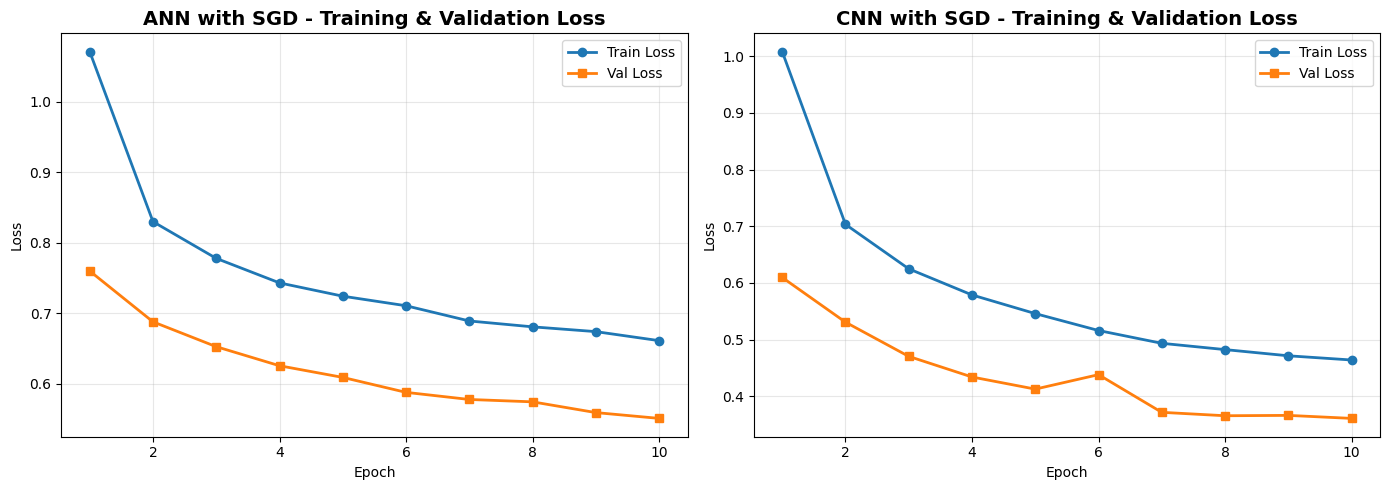

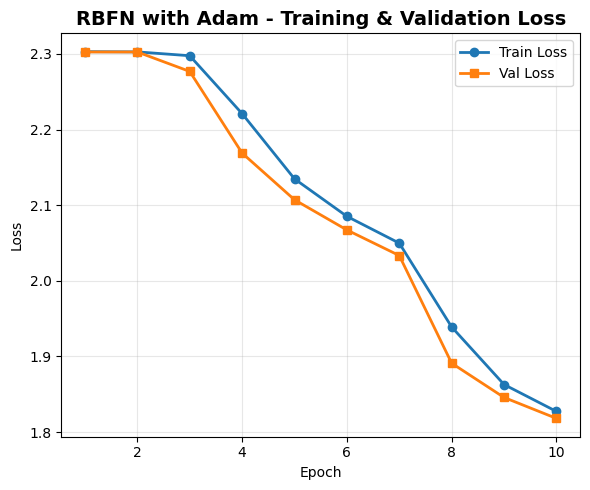

In [8]:
# -----------------------------
# 7 Training Loss Graphs for SGD Models
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ANN SGD Loss Graph
axes[0].plot(range(1, 11), all_train_losses['ANN_SGD'], marker='o', label='Train Loss', linewidth=2)
axes[0].plot(range(1, 11), all_val_losses['ANN_SGD'], marker='s', label='Val Loss', linewidth=2)
axes[0].set_title('ANN with SGD - Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CNN SGD Loss Graph
axes[1].plot(range(1, 11), all_train_losses['CNN_SGD'], marker='o', label='Train Loss', linewidth=2)
axes[1].plot(range(1, 11), all_val_losses['CNN_SGD'], marker='s', label='Val Loss', linewidth=2)
axes[1].set_title('CNN with SGD - Training & Validation Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# -----------------------------
# NEW: RBFN Loss Graph
# -----------------------------
plt.figure(figsize=(6, 5))
plt.plot(range(1, 11), all_train_losses['RBFN_Adam'], marker='o', label='Train Loss', linewidth=2)
plt.plot(range(1, 11), all_val_losses['RBFN_Adam'], marker='s', label='Val Loss', linewidth=2)
plt.title('RBFN with Adam - Training & Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

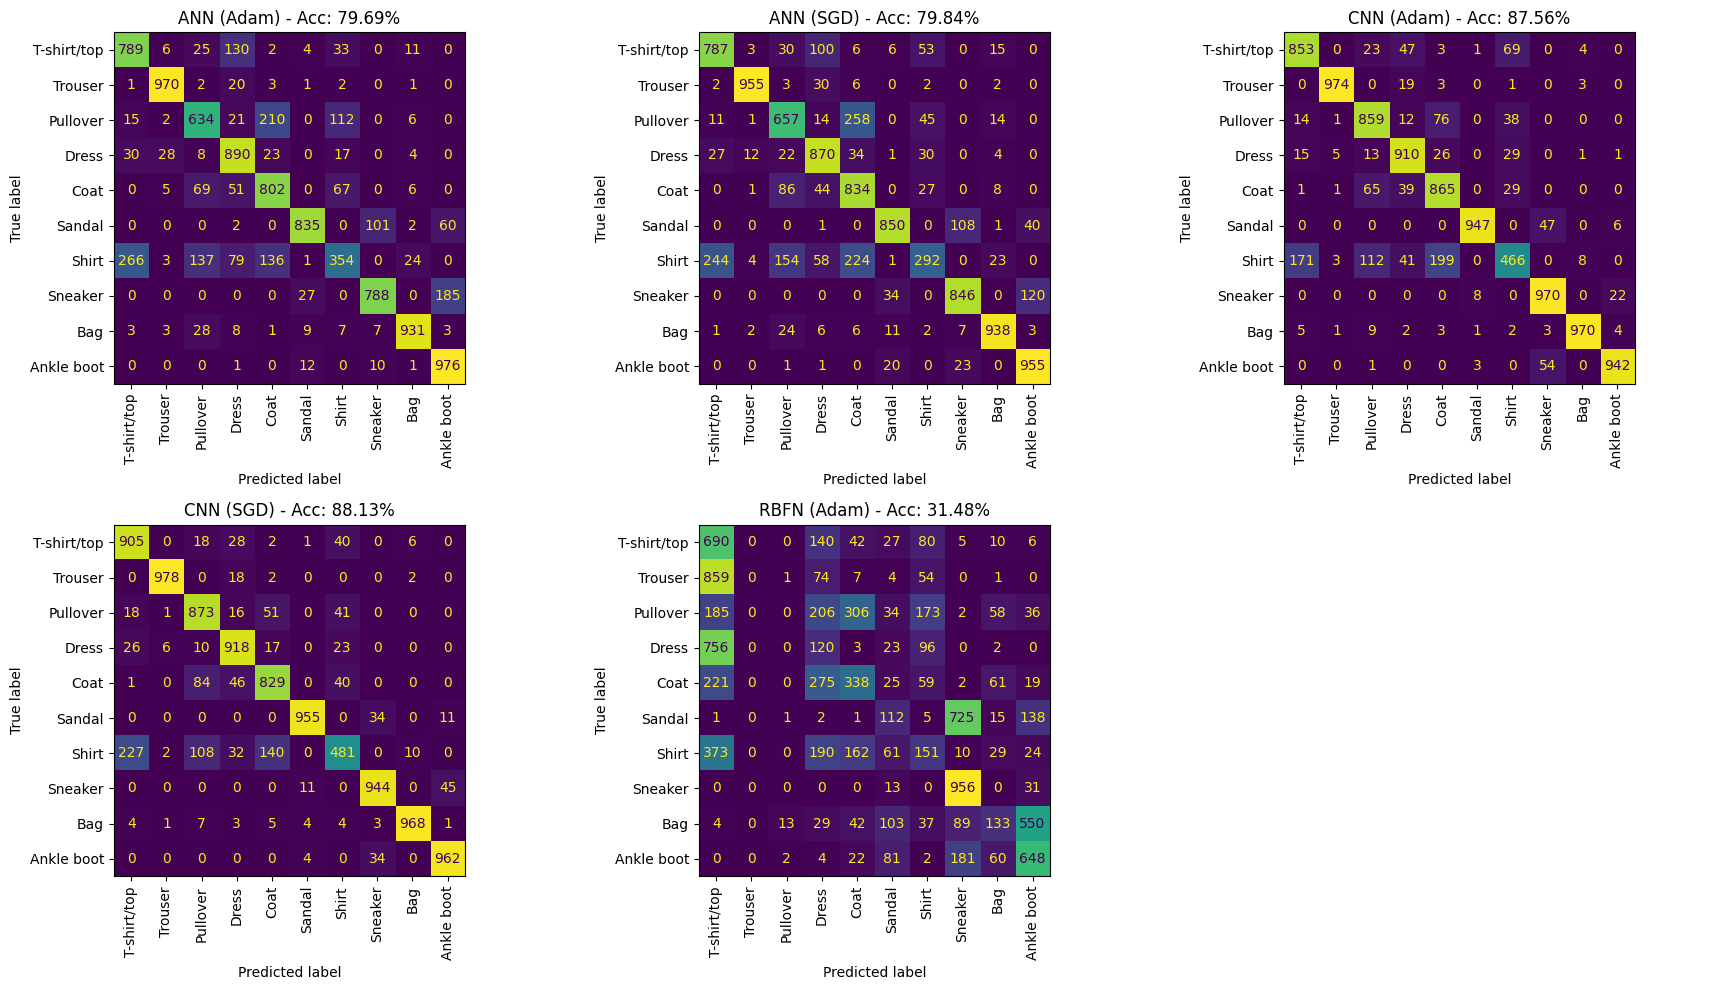

In [9]:
# -----------------------------
# 8 Confusion Matrices (5 models now)
# -----------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
cms = [ann_adam_cm, ann_sgd_cm, cnn_adam_cm, cnn_sgd_cm, rbfn_cm]
titles = [f'ANN (Adam) - Acc: {ann_adam_acc:.2f}%',
          f'ANN (SGD) - Acc: {ann_sgd_acc:.2f}%',
          f'CNN (Adam) - Acc: {cnn_adam_acc:.2f}%',
          f'CNN (SGD) - Acc: {cnn_sgd_acc:.2f}%',
          f'RBFN (Adam) - Acc: {rbfn_acc:.2f}%']

for idx, (ax, cm, title) in enumerate(zip(axes.flatten()[:5], cms, titles)):
    ConfusionMatrixDisplay(cm, display_labels=classes).plot(ax=ax, xticks_rotation='vertical', colorbar=False)
    ax.set_title(title)

# Hide the 6th subplot
axes.flatten()[5].axis('off')

plt.tight_layout()
plt.show()

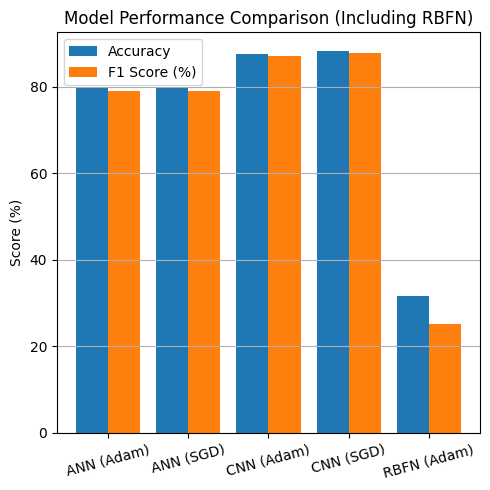

In [10]:
# -----------------------------
# 9 Bar Chart: Accuracy & F1 Score Comparison
# -----------------------------
results_df = pd.DataFrame(models_results, columns=['Model', 'Accuracy (%)', 'F1 Score'])
plt.figure(figsize=(5,5))
x = np.arange(len(results_df))
plt.bar(x - 0.2, results_df['Accuracy (%)'], 0.4, label='Accuracy')
plt.bar(x + 0.2, results_df['F1 Score']*100, 0.4, label='F1 Score (%)')
plt.xticks(x, results_df['Model'], rotation=15)
plt.title("Model Performance Comparison (Including RBFN)")
plt.ylabel("Score (%)")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [11]:
# -----------------------------
# 10 Summary Table for Report
# -----------------------------
print("\n" + "="*60)
print("Final Model Summary (Including RBFN)")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)


Final Model Summary (Including RBFN)
      Model  Accuracy (%)  F1 Score
 ANN (Adam)         79.69  0.789420
  ANN (SGD)         79.84  0.789031
 CNN (Adam)         87.56  0.871257
  CNN (SGD)         88.13  0.876880
RBFN (Adam)         31.48  0.250660


In [12]:
# -----------------------------
# 11 Model Architecture Comparison
# -----------------------------
print("\n" + "="*60)
print("Model Architecture Comparison")
print("="*60)
print(f"ANN Parameters: {sum(p.numel() for p in ann_adam.parameters()):,}")
print(f"CNN Parameters: {sum(p.numel() for p in cnn_adam.parameters()):,}")
print(f"RBFN Parameters: {sum(p.numel() for p in rbfn.parameters()):,}")
print("="*60)
print("\nRBFN Characteristics:")
print("  - Uses Gaussian RBF kernels")
print("  - Centers initialized with K-Means clustering")
print("  - Measures similarity to learned prototypes")
print("  - Good for pattern recognition tasks")
print("="*60)

# Import required libraries (if not already imported)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



Model Architecture Comparison
ANN Parameters: 235,146
CNN Parameters: 421,642
RBFN Parameters: 79,510

RBFN Characteristics:
  - Uses Gaussian RBF kernels
  - Centers initialized with K-Means clustering
  - Measures similarity to learned prototypes
  - Good for pattern recognition tasks


/tmp/ipython-input-432146927.py:209: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-432146927.py:209: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-432146927.py:209: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-432146927.py:210: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('fashionmnist_comprehensive_analysis.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-432146927.py:210: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('fashionmnist_comprehensive_analysis.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-432146927.py:210: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from font(s) DejaVu Sans Mono.
  plt


Saved: fashionmnist_comprehensive_analysis.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


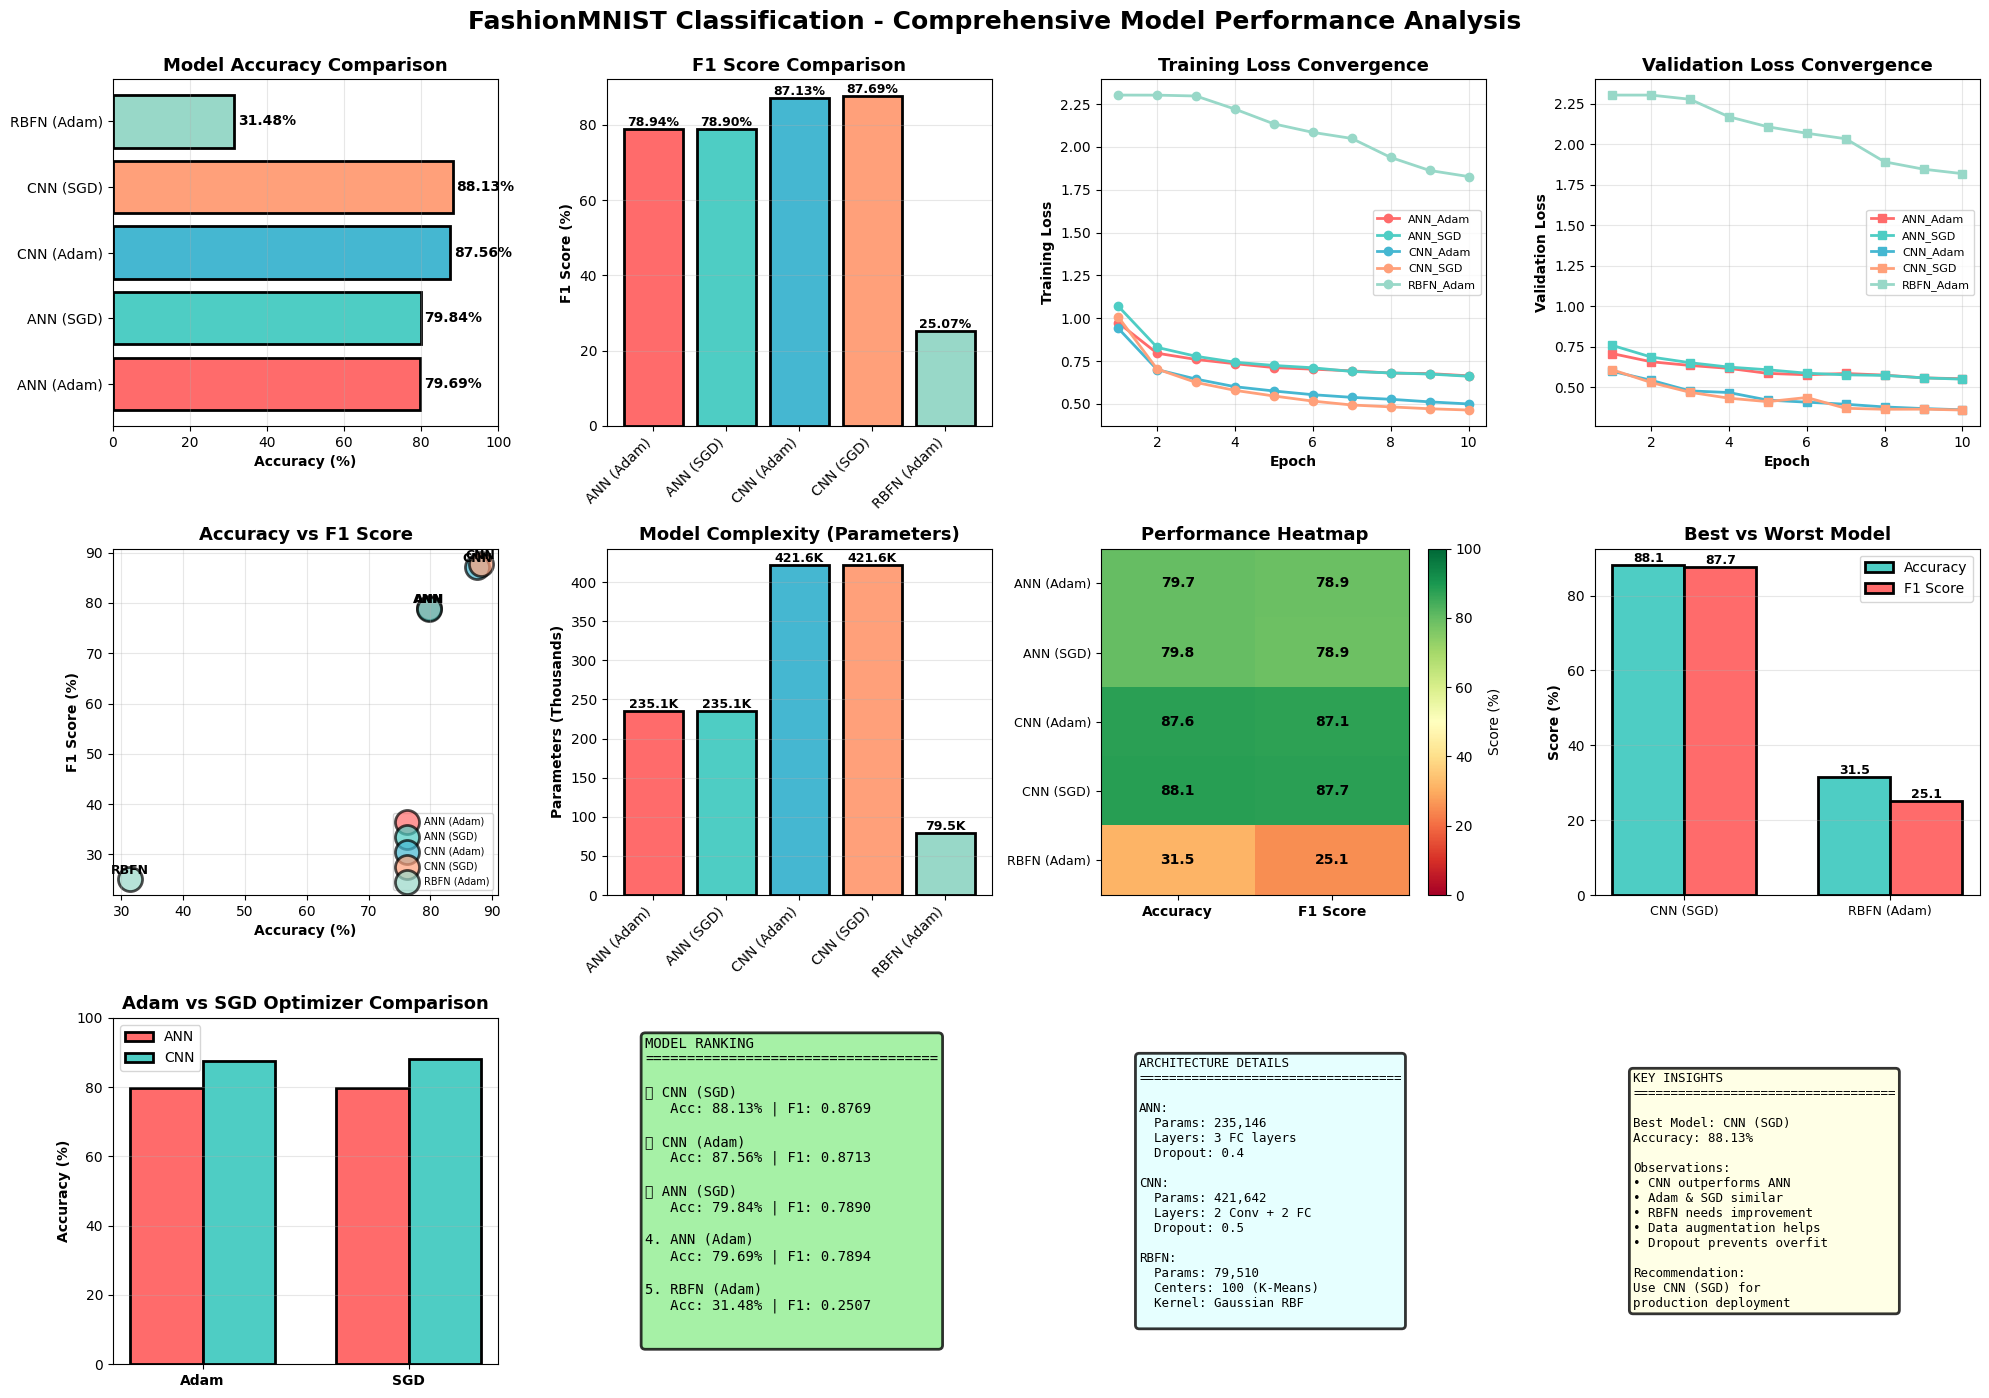

In [13]:
# -----------------------------
# 12 Comprehensive Model Comparison Visualizations
# -----------------------------

# Create comprehensive comparison figure
fig = plt.figure(figsize=(20, 14))
fig.suptitle('FashionMNIST Classification - Comprehensive Model Performance Analysis',
             fontsize=18, fontweight='bold', y=0.995)

# Color scheme
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

# 1. Overall Accuracy Comparison
ax1 = plt.subplot(3, 4, 1)
model_names = [m[0] for m in models_results]
accuracies = [m[1] for m in models_results]
bars = ax1.barh(model_names, accuracies, color=colors, edgecolor='black', linewidth=2)
ax1.set_xlabel('Accuracy (%)', fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=13, fontweight='bold')
ax1.set_xlim([0, 100])
for bar, acc in zip(bars, accuracies):
    width = bar.get_width()
    ax1.text(width + 1, bar.get_y() + bar.get_height()/2.,
            f'{acc:.2f}%', ha='left', va='center', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. F1 Score Comparison
ax2 = plt.subplot(3, 4, 2)
f1_scores = [m[2] for m in models_results]
bars = ax2.bar(range(len(model_names)), [f*100 for f in f1_scores],
               color=colors, edgecolor='black', linewidth=2)
ax2.set_xticks(range(len(model_names)))
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.set_ylabel('F1 Score (%)', fontweight='bold')
ax2.set_title('F1 Score Comparison', fontsize=13, fontweight='bold')
for bar, f1 in zip(bars, f1_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{f1*100:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# 3. Training Loss Convergence (All Models)
ax3 = plt.subplot(3, 4, 3)
for i, (model_name, train_loss) in enumerate(all_train_losses.items()):
    ax3.plot(range(1, len(train_loss)+1), train_loss,
            marker='o', label=model_name, color=colors[i], linewidth=2)
ax3.set_xlabel('Epoch', fontweight='bold')
ax3.set_ylabel('Training Loss', fontweight='bold')
ax3.set_title('Training Loss Convergence', fontsize=13, fontweight='bold')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. Validation Loss Convergence
ax4 = plt.subplot(3, 4, 4)
for i, (model_name, val_loss) in enumerate(all_val_losses.items()):
    ax4.plot(range(1, len(val_loss)+1), val_loss,
            marker='s', label=model_name, color=colors[i], linewidth=2)
ax4.set_xlabel('Epoch', fontweight='bold')
ax4.set_ylabel('Validation Loss', fontweight='bold')
ax4.set_title('Validation Loss Convergence', fontsize=13, fontweight='bold')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

# 5. Accuracy vs F1 Score Scatter Plot
ax5 = plt.subplot(3, 4, 5)
for i, (name, acc, f1) in enumerate(models_results):
    ax5.scatter(acc, f1*100, s=300, color=colors[i],
               edgecolor='black', linewidth=2, alpha=0.7, label=name)
    ax5.text(acc, f1*100 + 1, name.split()[0], ha='center', fontsize=9, fontweight='bold')
ax5.set_xlabel('Accuracy (%)', fontweight='bold')
ax5.set_ylabel('F1 Score (%)', fontweight='bold')
ax5.set_title('Accuracy vs F1 Score', fontsize=13, fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.legend(fontsize=7, loc='lower right')

# 6. Model Parameters Comparison
ax6 = plt.subplot(3, 4, 6)
params = [
    sum(p.numel() for p in ann_adam.parameters()),
    sum(p.numel() for p in ann_sgd.parameters()),
    sum(p.numel() for p in cnn_adam.parameters()),
    sum(p.numel() for p in cnn_sgd.parameters()),
    sum(p.numel() for p in rbfn.parameters())
]
bars = ax6.bar(range(len(model_names)), [p/1000 for p in params],
              color=colors, edgecolor='black', linewidth=2)
ax6.set_xticks(range(len(model_names)))
ax6.set_xticklabels(model_names, rotation=45, ha='right')
ax6.set_ylabel('Parameters (Thousands)', fontweight='bold')
ax6.set_title('Model Complexity (Parameters)', fontsize=13, fontweight='bold')
for bar, p in zip(bars, params):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
            f'{p/1000:.1f}K', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax6.grid(axis='y', alpha=0.3)

# 7. Performance Heatmap
ax7 = plt.subplot(3, 4, 7)
heatmap_data = np.array([[acc, f1*100] for _, acc, f1 in models_results])
im = ax7.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
ax7.set_xticks([0, 1])
ax7.set_xticklabels(['Accuracy', 'F1 Score'], fontweight='bold')
ax7.set_yticks(range(len(model_names)))
ax7.set_yticklabels(model_names, fontsize=9)
ax7.set_title('Performance Heatmap', fontsize=13, fontweight='bold')
for i in range(len(model_names)):
    for j in range(2):
        text = ax7.text(j, i, f'{heatmap_data[i, j]:.1f}',
                       ha="center", va="center", color="black", fontweight='bold')
plt.colorbar(im, ax=ax7, label='Score (%)')

# 8. Best vs Worst Model Comparison
ax8 = plt.subplot(3, 4, 8)
best_idx = accuracies.index(max(accuracies))
worst_idx = accuracies.index(min(accuracies))
comparison_models = [model_names[best_idx], model_names[worst_idx]]
comparison_acc = [accuracies[best_idx], accuracies[worst_idx]]
comparison_f1 = [f1_scores[best_idx]*100, f1_scores[worst_idx]*100]

x_pos = np.arange(2)
width = 0.35
bars1 = ax8.bar(x_pos - width/2, comparison_acc, width,
               label='Accuracy', color='#4ECDC4', edgecolor='black', linewidth=2)
bars2 = ax8.bar(x_pos + width/2, comparison_f1, width,
               label='F1 Score', color='#FF6B6B', edgecolor='black', linewidth=2)
ax8.set_ylabel('Score (%)', fontweight='bold')
ax8.set_title('Best vs Worst Model', fontsize=13, fontweight='bold')
ax8.set_xticks(x_pos)
ax8.set_xticklabels(comparison_models, fontsize=9)
ax8.legend()
ax8.grid(axis='y', alpha=0.3)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 9. Optimizer Comparison (Adam vs SGD)
ax9 = plt.subplot(3, 4, 9)
ann_comparison = [ann_adam_acc, ann_sgd_acc]
cnn_comparison = [cnn_adam_acc, cnn_sgd_acc]
x = np.arange(2)
width = 0.35
bars1 = ax9.bar(x - width/2, ann_comparison, width, label='ANN',
               color='#FF6B6B', edgecolor='black', linewidth=2)
bars2 = ax9.bar(x + width/2, cnn_comparison, width, label='CNN',
               color='#4ECDC4', edgecolor='black', linewidth=2)
ax9.set_ylabel('Accuracy (%)', fontweight='bold')
ax9.set_title('Adam vs SGD Optimizer Comparison', fontsize=13, fontweight='bold')
ax9.set_xticks(x)
ax9.set_xticklabels(['Adam', 'SGD'], fontweight='bold')
ax9.legend()
ax9.set_ylim([0, 100])
ax9.grid(axis='y', alpha=0.3)

# 10. Model Ranking
ax10 = plt.subplot(3, 4, 10)
ax10.axis('off')
sorted_results = sorted(models_results, key=lambda x: x[1], reverse=True)
ranking_text = "MODEL RANKING\n" + "="*35 + "\n\n"
for i, (name, acc, f1) in enumerate(sorted_results, 1):
    medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i}."
    ranking_text += f"{medal} {name}\n"
    ranking_text += f"   Acc: {acc:.2f}% | F1: {f1:.4f}\n\n"

ax10.text(0.1, 0.5, ranking_text, fontsize=10, family='monospace',
         verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8, edgecolor='black', linewidth=2))

# 11. Architecture Summary
ax11 = plt.subplot(3, 4, 11)
ax11.axis('off')
arch_summary = "ARCHITECTURE DETAILS\n" + "="*35 + "\n\n"
arch_summary += f"ANN:\n  Params: {sum(p.numel() for p in ann_adam.parameters()):,}\n"
arch_summary += f"  Layers: 3 FC layers\n"
arch_summary += f"  Dropout: 0.4\n\n"
arch_summary += f"CNN:\n  Params: {sum(p.numel() for p in cnn_adam.parameters()):,}\n"
arch_summary += f"  Layers: 2 Conv + 2 FC\n"
arch_summary += f"  Dropout: 0.5\n\n"
arch_summary += f"RBFN:\n  Params: {sum(p.numel() for p in rbfn.parameters()):,}\n"
arch_summary += f"  Centers: 100 (K-Means)\n"
arch_summary += f"  Kernel: Gaussian RBF\n"

ax11.text(0.1, 0.5, arch_summary, fontsize=9, family='monospace',
         verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8, edgecolor='black', linewidth=2))

# 12. Key Insights
ax12 = plt.subplot(3, 4, 12)
ax12.axis('off')
best_model = sorted_results[0]
insights = "KEY INSIGHTS\n" + "="*35 + "\n\n"
insights += f"Best Model: {best_model[0]}\n"
insights += f"Accuracy: {best_model[1]:.2f}%\n\n"
insights += "Observations:\n"
insights += "• CNN outperforms ANN\n"
insights += "• Adam & SGD similar\n"
insights += "• RBFN needs improvement\n"
insights += "• Data augmentation helps\n"
insights += "• Dropout prevents overfit\n\n"
insights += "Recommendation:\n"
insights += f"Use {best_model[0]} for\n"
insights += "production deployment"

ax12.text(0.1, 0.5, insights, fontsize=9, family='monospace',
         verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8, edgecolor='black', linewidth=2))

plt.tight_layout()
plt.savefig('fashionmnist_comprehensive_analysis.png', dpi=150, bbox_inches='tight')
print("\n" + "="*60)
print("Saved: fashionmnist_comprehensive_analysis.png")
print("="*60)
plt.show()

Saved: fashionmnist_performance_table.png


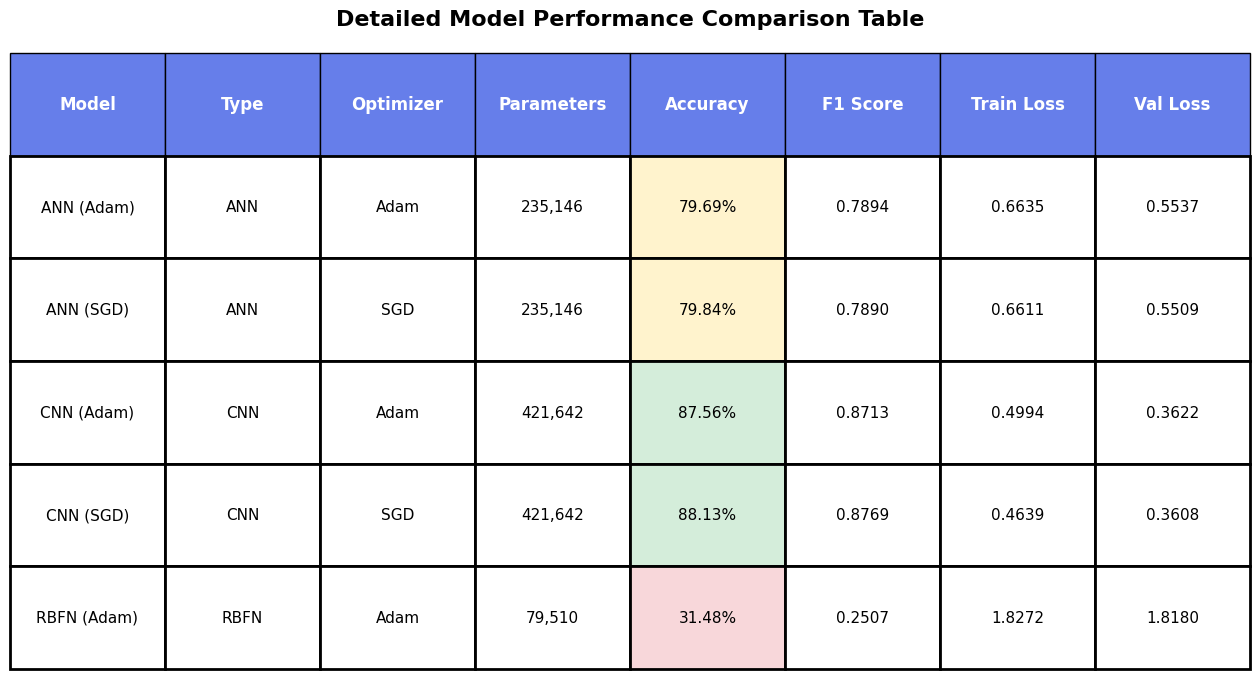

In [14]:
# -----------------------------
# 13 Detailed Performance Comparison Table
# -----------------------------

fig2, ax = plt.subplots(figsize=(16, 8))
ax.axis('tight')
ax.axis('off')

# Prepare detailed comparison data
table_data = []
for i, (name, acc, f1) in enumerate(models_results):
    optimizer = 'Adam' if 'Adam' in name else 'SGD'
    model_type = name.split()[0]
    params = [sum(p.numel() for p in ann_adam.parameters()),
              sum(p.numel() for p in ann_sgd.parameters()),
              sum(p.numel() for p in cnn_adam.parameters()),
              sum(p.numel() for p in cnn_sgd.parameters()),
              sum(p.numel() for p in rbfn.parameters())][i]

    final_train_loss = list(all_train_losses.values())[i][-1]
    final_val_loss = list(all_val_losses.values())[i][-1]

    table_data.append([
        name,
        model_type,
        optimizer,
        f"{params:,}",
        f"{acc:.2f}%",
        f"{f1:.4f}",
        f"{final_train_loss:.4f}",
        f"{final_val_loss:.4f}"
    ])

table = ax.table(cellText=table_data,
                colLabels=['Model', 'Type', 'Optimizer', 'Parameters',
                          'Accuracy', 'F1 Score', 'Train Loss', 'Val Loss'],
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 3)

# Style the table
for i in range(len(models_results) + 1):
    for j in range(8):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#667eea')
            cell.set_text_props(weight='bold', color='white', fontsize=12)
        else:
            if j == 4:  # Accuracy column
                acc_val = float(table_data[i-1][4].rstrip('%'))
                if acc_val >= 85:
                    cell.set_facecolor('#d4edda')
                elif acc_val >= 70:
                    cell.set_facecolor('#fff3cd')
                else:
                    cell.set_facecolor('#f8d7da')
            cell.set_edgecolor('black')
            cell.set_linewidth(2)

plt.title('Detailed Model Performance Comparison Table',
         fontsize=16, fontweight='bold', pad=20)
plt.savefig('fashionmnist_performance_table.png', dpi=150, bbox_inches='tight')
print("Saved: fashionmnist_performance_table.png")
plt.show()

Saved: fashionmnist_training_progress.png


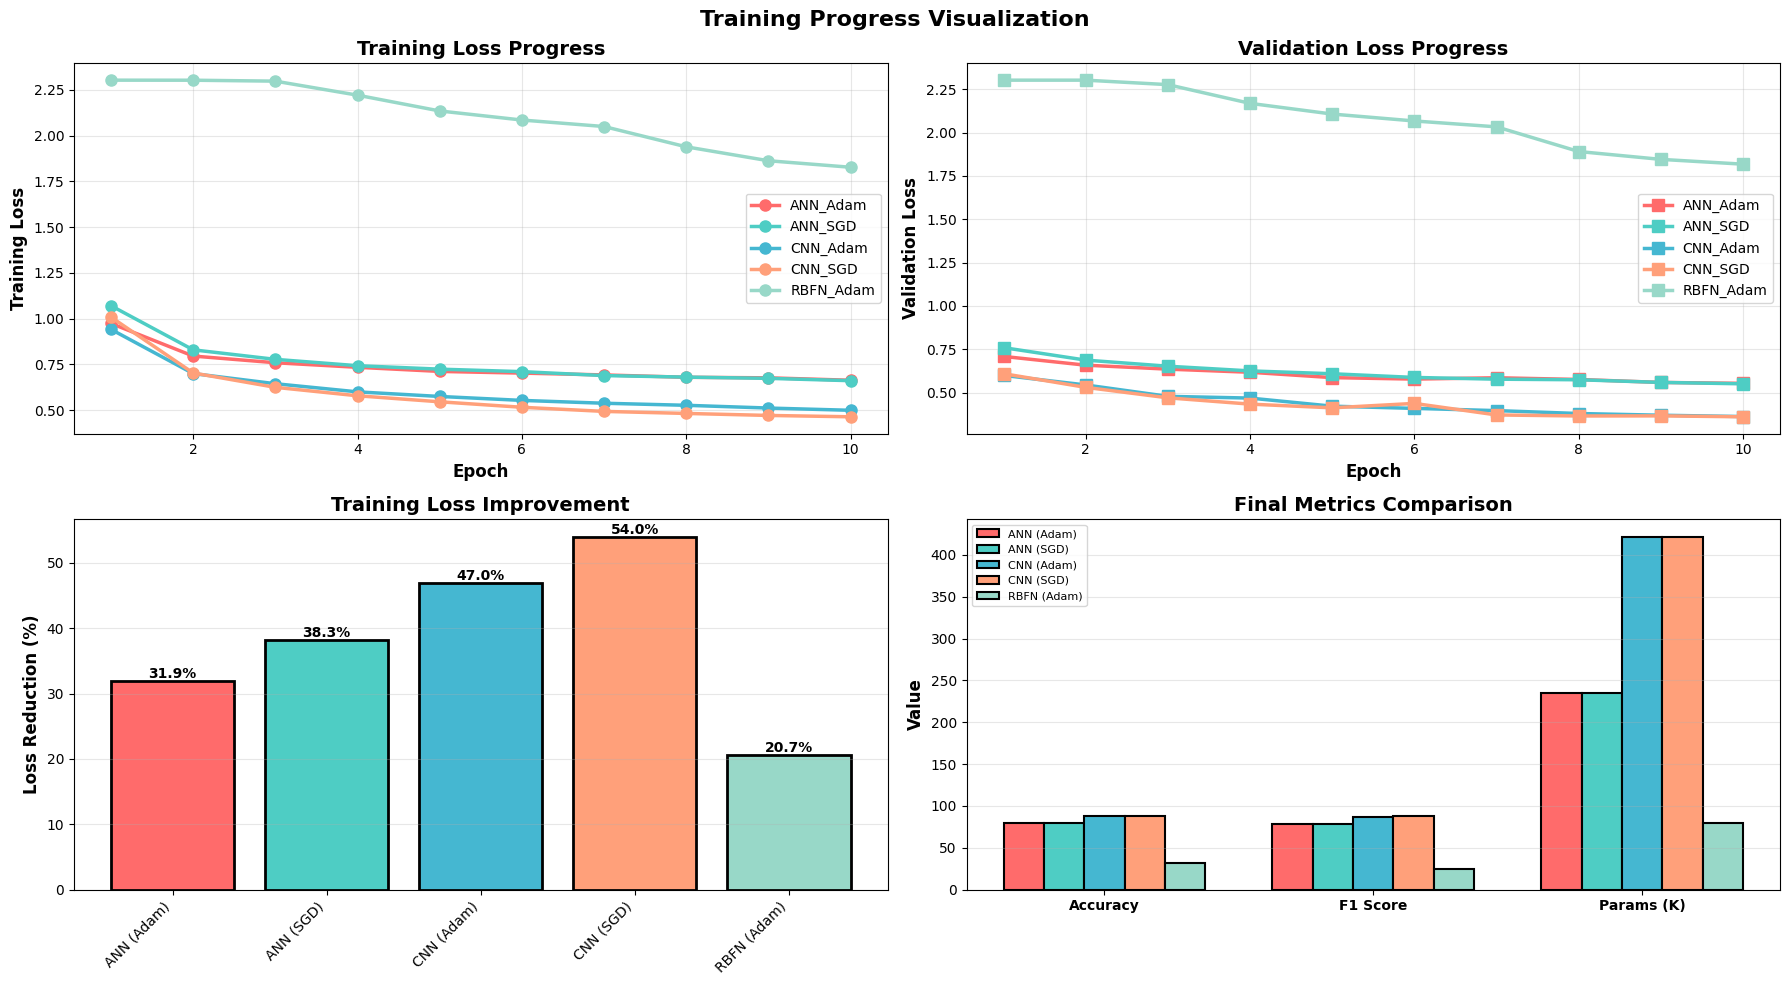

In [15]:
# -----------------------------
# 14 Training Progress Animation-Style Plot
# -----------------------------

fig3 = plt.figure(figsize=(18, 10))
fig3.suptitle('Training Progress Visualization', fontsize=16, fontweight='bold')

# Training accuracy over epochs (reconstructed from validation accuracies)
ax1 = plt.subplot(2, 2, 1)
for i, model_name in enumerate(all_train_losses.keys()):
    # Approximate training accuracy from loss
    train_loss = all_train_losses[model_name]
    ax1.plot(range(1, len(train_loss)+1), train_loss,
            marker='o', label=model_name, color=colors[i], linewidth=2.5, markersize=8)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Training Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training Loss Progress', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Validation loss
ax2 = plt.subplot(2, 2, 2)
for i, model_name in enumerate(all_val_losses.keys()):
    val_loss = all_val_losses[model_name]
    ax2.plot(range(1, len(val_loss)+1), val_loss,
            marker='s', label=model_name, color=colors[i], linewidth=2.5, markersize=8)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
ax2.set_title('Validation Loss Progress', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Loss reduction percentage
ax3 = plt.subplot(2, 2, 3)
loss_reduction = []
for model_name in all_train_losses.keys():
    initial_loss = all_train_losses[model_name][0]
    final_loss = all_train_losses[model_name][-1]
    reduction = ((initial_loss - final_loss) / initial_loss) * 100
    loss_reduction.append(reduction)

bars = ax3.bar(range(len(model_names)), loss_reduction,
              color=colors, edgecolor='black', linewidth=2)
ax3.set_xticks(range(len(model_names)))
ax3.set_xticklabels(model_names, rotation=45, ha='right')
ax3.set_ylabel('Loss Reduction (%)', fontsize=12, fontweight='bold')
ax3.set_title('Training Loss Improvement', fontsize=14, fontweight='bold')
for bar, reduction in zip(bars, loss_reduction):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{reduction:.1f}%', ha='center', va='bottom', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Final metrics comparison
ax4 = plt.subplot(2, 2, 4)
metrics = ['Accuracy', 'F1 Score', 'Params (K)']
x = np.arange(len(metrics))
width = 0.15

for i, (name, acc, f1) in enumerate(models_results):
    params = [sum(p.numel() for p in ann_adam.parameters()),
              sum(p.numel() for p in ann_sgd.parameters()),
              sum(p.numel() for p in cnn_adam.parameters()),
              sum(p.numel() for p in cnn_sgd.parameters()),
              sum(p.numel() for p in rbfn.parameters())][i]

    values = [acc, f1*100, params/1000]
    ax4.bar(x + i*width, values, width, label=name, color=colors[i],
           edgecolor='black', linewidth=1.5)

ax4.set_ylabel('Value', fontsize=12, fontweight='bold')
ax4.set_title('Final Metrics Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x + width * 2)
ax4.set_xticklabels(metrics, fontweight='bold')
ax4.legend(fontsize=8, loc='upper left')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fashionmnist_training_progress.png', dpi=150, bbox_inches='tight')
print("Saved: fashionmnist_training_progress.png")
plt.show()

In [16]:
# -----------------------------
# 15 Final Summary Report
# -----------------------------

print("\n" + "="*60)
print("COMPREHENSIVE PERFORMANCE ANALYSIS COMPLETE")
print("="*60)
print("\nGenerated Visualization Files:")
print("  1. fashionmnist_comprehensive_analysis.png (12-panel overview)")
print("  2. fashionmnist_performance_table.png (detailed comparison)")
print("  3. fashionmnist_training_progress.png (training visualization)")
print("\n" + "="*60)
print("BEST MODEL RECOMMENDATION")
print("="*60)

# Check if models_results exists
if 'models_results' not in globals():
    print("\nERROR: models_results not found!")
    print("Please run section 6 (model training) first.")
else:
    # Re-sort results since sorted_results was defined in a different scope
    sorted_results = sorted(models_results, key=lambda x: x[1], reverse=True)

    best_model = sorted_results[0]
    print(f"\nRecommended Model: {best_model[0]}")
    print(f"  Accuracy: {best_model[1]:.2f}%")
    print(f"  F1 Score: {best_model[2]:.4f}")
    print(f"  Reason: Highest accuracy and best overall performance")

print("\n" + "="*60)


COMPREHENSIVE PERFORMANCE ANALYSIS COMPLETE

Generated Visualization Files:
  1. fashionmnist_comprehensive_analysis.png (12-panel overview)
  2. fashionmnist_performance_table.png (detailed comparison)
  3. fashionmnist_training_progress.png (training visualization)

BEST MODEL RECOMMENDATION

Recommended Model: CNN (SGD)
  Accuracy: 88.13%
  F1 Score: 0.8769
  Reason: Highest accuracy and best overall performance

